# Intro to Building Mathematical Models of Signaling Pathways

**To Do**

- write intro
- make functions into modules
- fix phase portrait code

# Setting up environment

## Import Packages

In [443]:
# for solving systems of ODEs
from scipy.integrate import odeint
from scipy.optimize import fsolve # note: scipy.integrate.solve_ivp is updated function

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colorbar
import matplotlib.colors
import matplotlib.cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# basic data science packages
import numpy as np
import pandas as pd

# Evolutionary alogorithm tools
from deap import base, creator, tools, algorithms

## Import modules

In [552]:
def run(exp_dataY, exp_dataX, exp_time):
# def run(exp_data, exp_time):

    def scorefxn_helper(individual):
    # just a helper function that pulls all of scorefxn1 dependencies together
    # note the (), <--using single optimization in DEAP for now
    # scorefxn1 is taking care of the multiple optimizations for now
#         return scorefxn1(individual, exp_data, exp_time, convert=True),
        return scorefxn2(individual, exp_dataY, exp_dataX, exp_time, convert=True),
    
    runs = []
    for i in range(number_of_runs):
        ###################################################################
        #EVOLUTIONARY ALGORITHM
        ###################################################################
        #TYPE
        #Create minimizing fitness class w/ single objective:
        creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
        #Create individual class:
        creator.create('Individual', list, fitness=creator.FitnessMin)

        #TOOLBOX
        toolbox = base.Toolbox()
        #Register function to create a number in the interval [1-100?]:
        #toolbox.register('init_params', )
        #Register function to use initRepeat to fill individual w/ n calls to rand_num:
        toolbox.register('individual', tools.initRepeat, creator.Individual,
                         np.random.random, n=number_of_params)
        #Register function to use initRepeat to fill population with individuals:
        toolbox.register('population', tools.initRepeat, list, toolbox.individual)

        #GENETIC OPERATORS:
        # Register evaluate fxn = evaluation function, individual to evaluate given later
        toolbox.register('evaluate', scorefxn_helper)
        # Register mate fxn = two points crossover function
        toolbox.register('mate', tools.cxTwoPoint)
        # Register mutate by swapping two points of the individual:
        toolbox.register('mutate', tools.mutPolynomialBounded,
                         eta=0.1, low=0.0, up=1.0, indpb=0.2)
        # Register select = size of tournament set to 3
        toolbox.register('select', tools.selTournament, tournsize=3)

        #EVOLUTION!
        pop = toolbox.population(n=number_of_individuals)
        hof = tools.HallOfFame(1)

        stats = tools.Statistics(key = lambda ind: [ind.fitness.values, ind])
        stats.register('all', np.copy)

        # using built in eaSimple algo
        pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=crossover_rate,
                                           mutpb=mutation_rate,
                                           ngen=number_of_generations,
                                           stats=stats, halloffame=hof,
                                           verbose=False)
        # print(f'Run number completed: {i}')

        ###################################################################
        #MAKE LISTS
        ###################################################################
        # Find best scores and individuals in population
        arr_best_score = []
        arr_best_ind = []
        for a in range(len(logbook)):
            scores = []
            for b in range(len(logbook[a]['all'])):
                scores.append(logbook[a]['all'][b][0][0])
            #print(a, np.nanmin(scores), np.nanargmin(scores))
            arr_best_score.append(np.nanmin(scores))
            #logbook is of type 'deap.creator.Individual' and must be loaded later
            #don't want to have to load it to view data everytime, thus numpy
            ind_np = np.asarray(logbook[a]['all'][np.nanargmin(scores)][1])
            ind_np_conv = convert_individual(ind_np, arr_conversion_matrix, number_of_params)
            arr_best_ind.append(ind_np_conv)
            #arr_best_ind.append(np.asarray(logbook[a]['all'][np.nanargmin(scores)][1]))


        # print('Best individual is:\n %s\nwith fitness: %s' %(arr_best_ind[-1],arr_best_score[-1]))

        ###################################################################
        #PICKLE
        ###################################################################
        arr_to_pickle = [arr_best_score, arr_best_ind]
        runs.append(arr_to_pickle)
        if i % 5 == 0:
            print(str((i/number_of_runs)*100)+'% complete.')
    return runs

def convert_individual(ea_individual, conversion_matrix, number_of_params):
    # copy and get len of individual
    arr_params_conv = np.zeros(number_of_params)#np.copy(arr_parameters)
    len_ind = len(ea_individual)

    # Interp:
    for idx in np.nonzero(conversion_matrix[0])[0]:
        ea_val = ea_individual[idx]
        r_min = conversion_matrix[1][idx]
        r_max = conversion_matrix[2][idx]
        arr_params_conv[idx] = np.interp(ea_val, (0,1), (r_min, r_max))
        # print(ea_val)

    # Exponentiate:
    for idx in np.nonzero(conversion_matrix[3])[0]:
        ea_val = arr_params_conv[idx]
        base_val = conversion_matrix[4][idx]
        arr_params_conv[idx] = np.power(base_val, ea_val)

    # arr_params_conv[-4:] = np.round(arr_params_conv[-4:],0)

    return arr_params_conv



def make_conversion_matrix(number_of_params, maximums, minimums):
    # want easily savable matrix to hold this info
    # interp boolean, interp range (min,max), power boolean, power number (y)
    arr_IandP = np.zeros((5,number_of_params))
    # Set all interp booleans to 1 - everything is going to be interpreted
    arr_IandP[0,:] = 1
    # Set all power booleans to 1 - everything is in the form of powers
    arr_IandP[3,:] = 1
    # Set all power numbers to 10 - everything has a base of 10
    arr_IandP[4,:] = 10
    # Set minimums and maximums for all parameters. Parameters are in the following order:

    for i in range(len(minimums)):
        arr_IandP[1,i] = minimums[i] #interp_range_min
        arr_IandP[2,i] = maximums[i] #interp_range_max

    return arr_IandP

def scorefxn1(params, exp_data, exp_time, convert=False):
    
    if convert:
        params = convert_individual(params, arr_conversion_matrix, number_of_params)

    dt = 0.1
    steps = 601
    time = np.linspace(0,dt*steps,steps)

    closest_idxs = [np.abs(time - t).argmin() for t in exp_time]
#     closest_idxs_pbs2 = [np.abs(time - t).argmin() for t in pbs2_time]

    # check if wt steady state exists, returns maximal MSE if not
    ss_inits = run_ss(model, inits, params)

    # ADD checks for impossible values for steady state
    
    mse_total = 0

    # WILDTYPE
    for sig, exp_datum in zip(sigs, exp_data):
        odes = run_experiment(model, ss_inits, time, params, sig)
        fitted_species = odes[:,1]
#         print(fitted_species)

        error_wt = np.absolute(exp_datum - fitted_species[closest_idxs]).mean() #SSE
#         error_wt = np.sum((exp_datum - fitted_species[closest_idxs])**2)#.mean() #SSE
        mse_total += error_wt
        
#     print(params)
#     print(fitted_species[closest_idxs])
#     print(np.absolute(exp_datum - fitted_species[closest_idxs]))
#     print(ss_inits)
#     print(mse_total)

    return mse_total

def scorefxn2(params, exp_dataY, exp_dataX, exp_time, convert=False):
    
    if convert:
        params = convert_individual(params, arr_conversion_matrix, number_of_params)

    dt = 0.1
    steps = 601
    time = np.linspace(0,dt*steps,steps)

    closest_idxs = [np.abs(time - t).argmin() for t in exp_time]

    # check if wt steady state exists, returns maximal MSE if not
    ss_inits = run_ss(model2, inits, params)

    # ADD checks for impossible values for steady state
    
    mse_total = 0

    # WILDTYPE
    for sig, exp_datumY, exp_datumX in zip(sigs, exp_dataY, exp_dataX):
        odes = run_experiment(model2, ss_inits, time, params, sig)
        fitted_speciesY = odes[:,1]
        fitted_speciesX = odes[:,0]


        error_wt = np.sum((exp_datumY - fitted_speciesY[closest_idxs])**2) #SSE
#         error_wt = np.absolute(exp_datumY - fitted_speciesY[closest_idxs]).mean() #mean

        mse_total += error_wt

        error_wt = np.sum((exp_datumX - fitted_speciesX[closest_idxs])**2) #SSE
#         error_wt = np.absolute(exp_datumX - fitted_speciesX[closest_idxs]).mean() #mean

        mse_total += error_wt

    # print(mse_total)
    return mse_total

def sort_sims(runs, gen=-1):
    mses = np.array([runs[i][0][gen] for i in range(len(runs))])
    params = np.array([runs[i][1][gen] for i in range(len(runs))])

    return mses[np.argsort(mses)], params[np.argsort(mses)]
    
def plt_param_ranges(labelnames, dims, runs_sort, num_plt, synth_data=None, save_fig=''):
    # fig, (ax1) = plt.subplots(1, 1, figsize=(3,3))
    fig, (ax1) = plt.subplots(1, 1, figsize=(2.5,1.5))

#     pal = sns.set_palette(param_colors.get(m_name))



    # Hide the right and top spiness
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')

    major_ticks = np.arange(-2, 2.1, 1)
    ax1.set_yticks(major_ticks)
    
    #data handling
    df_param = pd.DataFrame(runs_sort[1][:num_plt])
    df_param.columns = labelnames
    df_param_log = df_param.apply(np.log10)
    df_melt = df_param_log.melt(var_name='param', value_name='vals')
        
    df_error = pd.DataFrame(runs_sort[0][:num_plt], columns=['error'])
    mses_df=df_error['error'].copy() 
    mses_df = pd.concat([mses_df]*5, ignore_index=True)
    df_plot = pd.concat([df_melt,mses_df], axis=1)
    
    pal = sns.light_palette("purple", reverse=True, as_cmap=True )
#     cmap    = sns.light_palette("seagreen", reverse=False, as_cmap=True )
    # Normalize to the range of possible values from df["c"]
    norm = matplotlib.colors.Normalize(vmin=df_error['error'].min(), vmax=df_error['error'].max())
    # create a color dictionary (value in c : color from colormap) 
    colors = {}
    for cval in df_plot["error"]:
        colors.update({cval : pal(norm(cval))})
    
    with sns.axes_style("whitegrid"):
        plt.bar(range(0,len(labelnames)),height=dims[0],bottom=dims[1],align='center',tick_label=labelnames, color='#dcdcdc',alpha = 0.8)
        ax1 = sns.swarmplot(x='param',y='vals', data = df_plot, hue='error', palette=colors, size=5) #size 3
        ax1.set_xticklabels(labelnames,rotation=90)
#         plt.xlabel('Parameters', fontsize=20, fontweight='medium')


    plt.grid(color='#606060', which='major', axis='y', linestyle='solid')
    if synth_data.any:
#         synth_data['param']=synth_data.index
#         synth_data.melt(var_name='param', value_name='vals')
        print(synth_data)
        ax1 = sns.swarmplot(data = synth_data, color = 'black', size=8, alpha=1, marker='*')
    ax1.set_ylabel('')
    ax1.set_xlabel('')

    plt.gca().legend_.remove()
    ## create colorbar ##
    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig.add_axes(ax_cb)
    cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=pal,
                                    norm=norm,
                                    orientation='vertical')
#     cb1.set_label('SSE')
    # a=ax1.get_yticks().tolist()
    # y_names=['$10^{-6}$','$10^{-4}$','$10^{-2}$','$1$','$10^{2}$','$10^{4}$','$10^{6}$',]
#     y_names=['$10^{-2}$','$10^{-1}$','$1$','$10^{1}$','$10^{2}$']
#     ax1.set_yticklabels(y_names)
#     ax1.legend_.remove()
#     ax1.legend([])

    if save_fig:
        plt.savefig(fig_folder+save_fig, dpi=300,bbox_inches='tight')   
    plt.show()    
    
    


## Plotting settings

In [532]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [2.5, 1.5]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 10
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

fig_folder = './Figs/'
fig_folder = 'C:/Users/sksuzuki/Documents/Research/Thesis/Dissertation/Figures/Chapter 1/Fig5/'

In [375]:
def model(inits, t, var, sig):
    X, Y = inits 
    B, kb, s1, d1, d2 = var
        
    dX = kb + sig - B * Y - d1 * X
    dY = s1 * X - d2*Y  # * (Y_t-Y)
     
    return dX, dY

In [8]:
def run_ss(model, inits, var):
    return fsolve(model, inits, args=(0,var, 0))

def run_experiment(model, ss, time, var, sig):
    return odeint(model, ss, time, args=(var, sig))

# Phase Plane

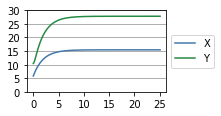

In [307]:
time = np.linspace(0, 25.1, 601)

sig = 5

X = 0
Y = 0
inits = [X, Y]

B = .01
kb = 3
s1 = 9
d1 = .5
d2 = 5
var = [B, kb, s1, d1, d2]


test_inits = run_ss(model, inits, var)
test_data = run_experiment(model, test_inits, time, var, sig) 

fig, ax1 = plt.subplots(1, 1)
ax1.plot(time, test_data[:,0], label="X", color = '#4478ab')
ax1.plot(time, test_data[:,1], label="Y", color = '#258942')

plt.grid(color='#606060', which='major', axis='y', linestyle='solid',linewidth=.5)
ax1.set_yticks(np.arange(0, 31, step=5))
ax1.set_xticks(np.arange(0, 26, step=5))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(fig_folder+'5B.jpg', dpi=300,bbox_inches='tight')

<Figure size 180x108 with 0 Axes>

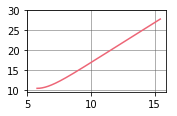

In [195]:
x, y = sys(test_inits[0], test_inits[1], 0.01, 5001)

plt.clf()
fig, ax1 = plt.subplots(1,1)
ax1.plot(x, y, color="#ed6677")
# ax2.set_xlabel("x")
# ax2.set_ylabel("y")  
# ax2.set_title("Phase space")
ax1.grid(color='#606060', which='major', linestyle='solid',linewidth=.5)
ax1.set_yticks(np.arange(10, 31, step=5))
ax1.set_xticks(np.arange(5, 16, step=5))

plt.savefig(fig_folder+'5B2.jpg', dpi=300,bbox_inches='tight')

In [220]:
fp = []

def find_fixed_points(r):
    for x in np.arange(0,r,.1):
        for y in np.arange(0,r,.1):
            if ((f(x,y) == 0) and (g(x,y) == 0)):
                fp.append((x,y))
                print('The system has a fixed point in %s,%s' % (x,y))
    return fp

find_fixed_points(5)

[]

In [308]:
time = np.linspace(0, 25.1, 601)

sig = 5

X = 0
Y = 0
inits = [X, Y]

B = 1
kb = .1
s1 = 2
d1 = .5
d2 = .5
var = [B, kb, s1, d1, d2]

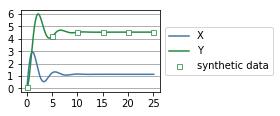

In [535]:
synth_ss_inits = run_ss(model, inits, var)
sim_data = run_experiment(model, synth_ss_inits, time, var, sig) 

fig, ax1 = plt.subplots(1, 1)
ax1.plot(time, sim_data[:,0], label="X", color = '#4478ab')
ax1.plot(time, sim_data[:,1], label="Y", color = '#258942')


plt.grid(color='#606060', which='major', axis='y', linestyle='solid',linewidth=.5)
ax1.set_yticks(np.arange(0, 7, step=1))
ax1.set_xticks(np.arange(0, 26, step=5))

plt.plot(synth_time, Y_data_synth, marker='s', linestyle="None", markersize=5, alpha=1, markeredgewidth=.75, markeredgecolor='#258942', markerfacecolor='white', label= 'synthetic data')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(fig_folder+'8A.jpg', dpi=300,bbox_inches='tight')

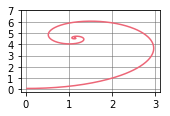

In [281]:
def f(X,Y):
#     return 2*x - x**2 - x*y
    return kb + sig - B * Y - d1 * X
def g(X,Y):
#     return - y + x*y
    return s1 * X - d2*Y

# initialize lists containing values
# x = []
# y = []

#iv1, iv2 = initial values, dt = timestep, time = range
def sys(iv1, iv2, dt, time):
    # initial values:
    x = []
    y = []

    x.append(iv1)
    y.append(iv2)
    #z.append(iv3)
    # compute and fill lists
    for i in range(time):
        x.append(x[i] + (f(x[i],y[i])) * dt)
        y.append(y[i] + (g(x[i],y[i])) * dt)
        #z.append(z[i] + (h(x[i],y[i],z[i])) * dt)
    return x, y

x, y = sys(synth_ss_inits[0], synth_ss_inits[1], 0.01, 5001)


fig, ax1 = plt.subplots(1,1)
ax1.plot(x, y, color="#ed6677")
# ax2.set_xlabel("x")
# ax2.set_ylabel("y")  
# ax2.set_title("Phase space")
ax1.grid(color='#606060', which='major', linestyle='solid',linewidth=.5)
ax1.set_yticks(np.arange(0, 8, step=1))
ax1.set_xticks(np.arange(0, 4, step=1))

plt.savefig(fig_folder+'5B4.jpg', dpi=300,bbox_inches='tight')

# Check phase portrait

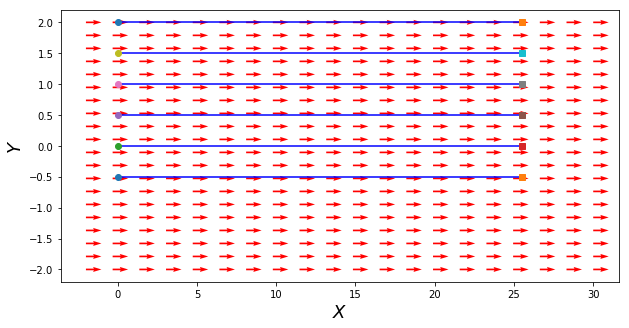

In [289]:
y1 = np.linspace(-2.0, 30.0, 20)
y2 = np.linspace(-2.0, 2.0, 20)

Y1, Y2 = np.meshgrid(y1, y2)

t = 0

u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

NI, NJ = Y1.shape

def test(Y, t):
    y1, y2 = Y
    return [y2, -np.sin(y1)]

for i in range(NI):
    for j in range(NJ):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = model([x,y], t, var, sig)
#         yprime = test([x,y], t)

        u[i,j] = yprime[0]
        v[i,j] = yprime[1]

Q = plt.quiver(Y1, Y2, u, v, color='r')

plt.xlabel('$X$')
plt.ylabel('$Y$')
# plt.xlim([-2, 8])
# plt.ylim([-4, 4])
plt.rcParams['figure.figsize'] = [10, 5]
# plt.show()
# plt.savefig(fig_folder+'test.png')

for y20 in [-0.5, 0, 0.5, 1, 1.5, 2]:
    tspan = np.linspace(0, 5, 2)
    y0 = [0.0, y20]
    ys = odeint(model, y0, tspan, args=(var, sig))
    plt.plot(ys[:,0], ys[:,1], 'b-') # path
    plt.plot([ys[0,0]], [ys[0,1]], 'o') # start
    plt.plot([ys[-1,0]], [ys[-1,1]], 's') # end

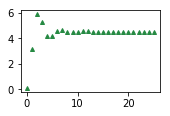

In [298]:
# synthetic data
synth_time = range(0,26,5)
closest_idxs = [np.abs(time - t).argmin() for t in synth_time]
Y_data_synth = sim_data[:,1][closest_idxs]
X_data_synth = sim_data[:,0][closest_idxs]

synth_time2 = range(0,26,1)
closest_idxs2 = [np.abs(time - t).argmin() for t in synth_time2]
Y_data_synth2 = sim_data[:,1][closest_idxs2]
X_data_synth2 = sim_data[:,0][closest_idxs2]

# plt.plot(synth_time, Y_data_synth, color='orange', marker='o', linestyle="None")
plt.plot(synth_time2, Y_data_synth2, color='#258942', marker='^', linestyle="None", markersize=4, alpha=1)


# Parameter Fitting with the EA

In [387]:
# Parameter ranges
number_of_params = 5
minimums = [-2, -2, -2, -2, -2]
maximums = [2, 2, 2, 2, 2]
diff = np.asarray(maximums)-np.asarray(minimums) #for plotting
dims = (diff, minimums) #for plotting

labelnames = ['$B$','$k_b$','$s_1$','$d_1$','$d_2$']

# EA params
number_of_runs = 50
number_of_generations = 50
number_of_individuals = 200
mutation_rate = 0.1
crossover_rate = 0.5

arr_conversion_matrix = make_conversion_matrix(number_of_params, maximums, minimums)

green = '#228833'
blue = '#4477AA'

sigs = [5]
# exp_data = [Y_data_synth]

## Runs to 5 min interval, just Y

In [347]:
runs = run([Y_data_synth], synth_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.0% complete.
10.0% complete.
20.0% complete.
30.0% complete.
40.0% complete.
50.0% complete.
60.0% complete.
70.0% complete.
80.0% complete.
90.0% complete.


In [348]:
len(runs)

50

In [349]:
len(runs[0][0])

51

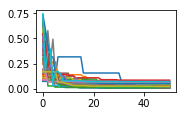

In [350]:
for i in range(len(runs)):
    mses = runs[i][0]
    plt.plot(range(len(mses)), mses)

In [537]:
sim_data = []
closest_idxs = [np.abs(time - t).argmin() for t in synth_time]
runs_sort = sort_sims(runs)
for param in runs_sort[1]:
    ss_inits = run_ss(model, inits, param)
    sim_datum = run_experiment(model, ss_inits, time, param, sig) 
#     sim_datum2 = run_experiment(model, ss_inits, time, param, sig)
    sim_data.append(sim_datum)

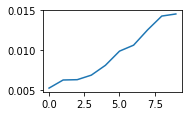

In [538]:
plt.plot(range(len(runs[:10])), runs_sort[0][:10])

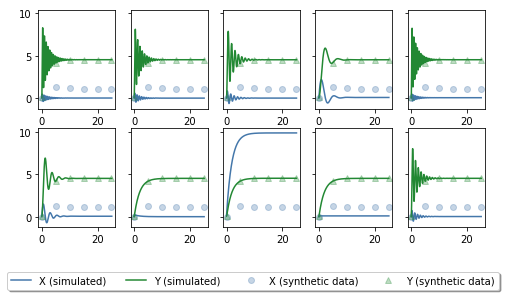

In [539]:
fig, axs = plt.subplots(2, 5, figsize=(8, 4), sharey=True)
for datum, i in zip(sim_data[:5], range(5)):
    axs[0,i].plot(time, datum[:,0], color=blue, label='X (simulated)')
    axs[0,i].plot(time, datum[:,1], color=green, label='Y (simulated)')
    axs[0,i].plot(synth_time, Y_data_synth, color=green, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')
    axs[0,i].plot(synth_time, X_data_synth, color=blue, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')


for datum, i in zip(sim_data[5:10], range(5)):
    axs[1,i].plot(time, datum[:,0], color=blue, label='X (simulated)')
    axs[1,i].plot(time, datum[:,1], color=green, label='Y (simulated)')
    axs[1,i].plot(synth_time, X_data_synth, color=blue, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')
    axs[1,i].plot(synth_time, Y_data_synth, color=green, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')

plt.legend(loc='upper right', bbox_to_anchor=(1.25, -0.40),
          fancybox=True, shadow=True, ncol=5)


plt.savefig(fig_folder+'8B.jpg', dpi=300,bbox_inches='tight')

   $B$  $k_b$    $s_1$    $d_1$    $d_2$
0  0.0   -1.0  0.30103 -0.30103 -0.30103


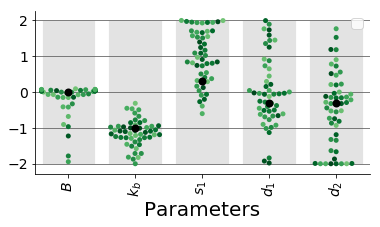

In [457]:
num_plt = 100
df_plt = pd.DataFrame(runs_sort[1][:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

synth_data_df = pd.DataFrame(var).T
synth_data_df.columns = labelnames
synth_data_df_log = synth_data_df.apply(np.log10)

plt_param_ranges(labelnames, dims, runs_sort, 100,  synth_data=synth_data_df_log) #black dot is best param


In [454]:
runs_sort[1][2]

array([1.0994688 , 0.1070828 , 1.33658255, 0.01048486, 3.27947906])

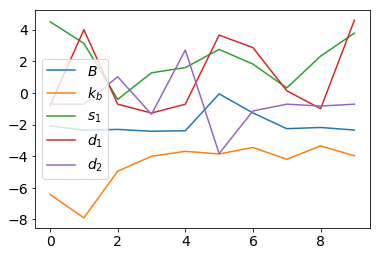

In [436]:
sse_params = []
for param in runs_sort[1]:
    sse = [np.absolute(x-p) for x, p in zip(var,param)]
    sse_params.append(sse)
    
# plt.plot(range(len(runs2)), sse_params)
plt.plot(range(len(runs))[:10], np.log(sse_params[:10]))
# plt.plot(range(len(runs))[:10], sse_params[:10])
plt.legend(labelnames)
# plt.plot(range(len(runs))[:5], np.log([(x-p)**2 for x, p in zip(var,var)]))

## Runs to 5 min interval, both Y and X

In [376]:
runs4 = run([Y_data_synth], [X_data_synth],synth_time)

0.0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


10.0% complete.
20.0% complete.
30.0% complete.
40.0% complete.
50.0% complete.
60.0% complete.
70.0% complete.
80.0% complete.
90.0% complete.


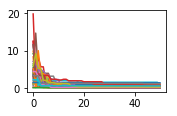

In [377]:
for i in range(len(runs)):
    mses = runs4[i][0]
    plt.plot(range(len(mses)), mses)

In [378]:
sim_data4 = []
closest_idxs = [np.abs(time - t).argmin() for t in synth_time]
runs_sort4 = sort_sims(runs4)
for param in runs_sort4[1]:
    ss_inits = run_ss(model, inits, param)
    sim_datum = run_experiment(model, ss_inits, time, param, sig) 
#     sim_datum2 = run_experiment(model, ss_inits, time, param, sig)
    sim_data4.append(sim_datum)

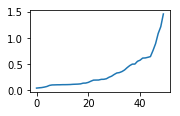

In [379]:
plt.plot(range(len(runs)), runs_sort4[0])

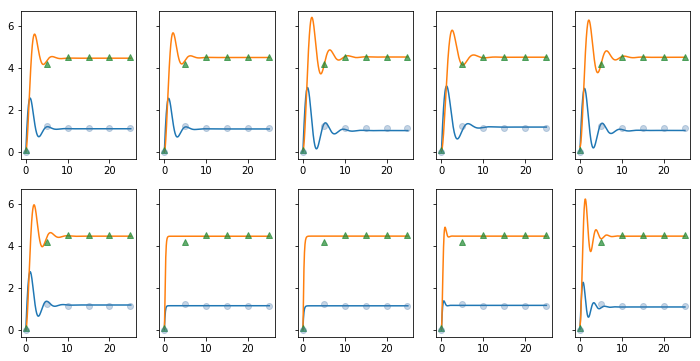

In [654]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6), sharey=True)
for datum, i in zip(sim_data4[:5], range(5)):
    axs[0,i].plot(time, datum)
    axs[0,i].plot(synth_time, Y_data_synth, color=green, marker='^', linestyle="None", alpha=.7)
    axs[0,i].plot(synth_time, X_data_synth, color=blue, marker='o', linestyle="None", alpha=.3)
for datum, i in zip(sim_data4[5:], range(5)):
    axs[1,i].plot(time, datum)
    axs[1,i].plot(synth_time, Y_data_synth, color=green, marker='^', linestyle="None", alpha=.7)
    axs[1,i].plot(synth_time, X_data_synth, color=blue, marker='o', linestyle="None", alpha=.3)


   $B$  $k_b$    $s_1$    $d_1$    $d_2$
0  0.0   -1.0  0.30103 -0.30103 -0.30103


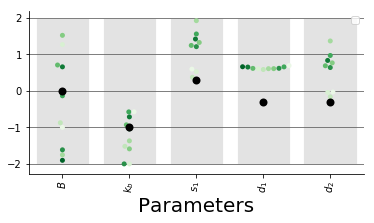

In [372]:
num_plt = 100
df_plt = pd.DataFrame(runs_sort4[1][:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

synth_data_df = pd.DataFrame(var).T
synth_data_df.columns = labelnames
synth_data_df_log = synth_data_df.apply(np.log10)

plt_param_ranges(labelnames, dims, runs_sort4, 10,  synth_data=synth_data_df_log) #black dot is best param


## Runs to 1 min interval, just Y

In [345]:
runs2 = run([Y_data_synth2], synth_time2)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


KeyboardInterrupt: 

In [335]:
sim_data2 = []

runs_sort2 = sort_sims(runs2)

for param in runs_sort2[1]:
    ss_inits = run_ss(model, inits, param)
    sim_datum = run_experiment(model, ss_inits, time, param, sig) 
    sim_data2.append(sim_datum)

(array([ 4.,  4.,  7.,  3.,  5., 12.,  5.,  7.,  1.,  2.]),
 array([0.01994355, 0.0426136 , 0.06528365, 0.0879537 , 0.11062375,
        0.1332938 , 0.15596385, 0.1786339 , 0.20130394, 0.22397399,
        0.24664404]),
 <a list of 10 Patch objects>)

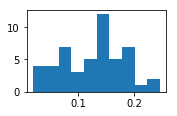

In [337]:
plt.hist(runs_sort2[0])

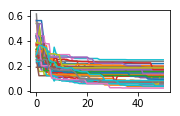

In [425]:
for i in range(len(runs2)):
    mses = runs2[i][0]
    plt.plot(range(len(mses)), mses)
plt.savefig(fig_folder+'6B.jpg', dpi=300,bbox_inches='tight')   

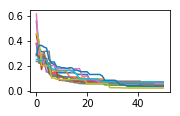

In [424]:
for i in range(len(runs2)):
    mses = runs2[i][0]
    if mses[-1] <= runs_sort2[0][10]:
        plt.plot(range(len(mses)), mses)
plt.savefig(fig_folder+'6Bi.jpg', dpi=300,bbox_inches='tight')    

   $B$  $k_b$    $s_1$    $d_1$    $d_2$
0  0.0   -1.0  0.30103 -0.30103 -0.30103


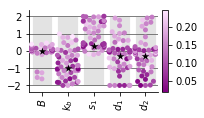

In [514]:
# use
# df_top_thetas_EA = pd.DataFrame(runs_sort2[1])
# df_top_thetas_EA.columns = labelnames

num_plt = 100
df_plt = pd.DataFrame(runs_sort2[1][:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

synth_data_df = pd.DataFrame(var).T
synth_data_df.columns = labelnames
synth_data_df_log = synth_data_df.apply(np.log10)


plt_param_ranges(labelnames, dims, runs_sort2, 100,  synth_data=synth_data_df_log, save_fig='6C.jpg') #black dot is best param

   $B$  $k_b$    $s_1$    $d_1$    $d_2$
0  0.0   -1.0  0.30103 -0.30103 -0.30103


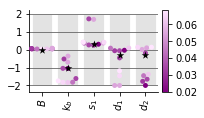

In [515]:
num_plt = 10
df_plt = pd.DataFrame(runs_sort2[1][:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

synth_data_df = pd.DataFrame(var).T
synth_data_df.columns = labelnames
synth_data_df_log = synth_data_df.apply(np.log10)


plt_param_ranges(labelnames, dims, runs_sort2, 10,  synth_data=synth_data_df_log, save_fig='6Ci.jpg') #black dot is best param
# plt.savefig(fig_folder+'6Ci.jpg', dpi=300,bbox_inches='tight')   

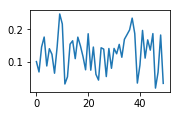

In [339]:
plt.plot(range(len(runs2)), [runs2[i][0][-1] for i in range(len(runs2))])

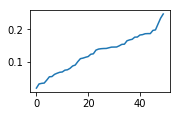

In [340]:
plt.plot(range(len(runs2)), runs_sort2[0])

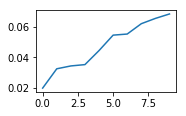

In [341]:
plt.plot(range(len(runs2[:10])), runs_sort2[0][:10])

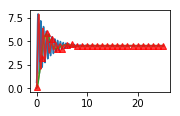

In [342]:
for datum in sim_data2[11:15]:
    plt.plot(time, datum[:,1])
    plt.plot(synth_time2, Y_data_synth2, color='red', marker='^', linestyle="None", alpha=.3)
#     pltplot(synth_time2, X_data_synth2, color='blue', marker='o', linestyle="None", alpha=.3)

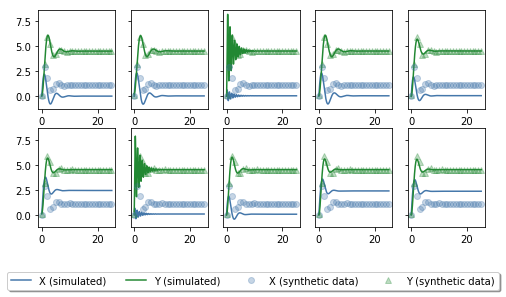

In [502]:
fig, axs = plt.subplots(2, 5, figsize=(8, 4), sharey=True)
for datum, i in zip(sim_data2[:5], range(5)):
    axs[0,i].plot(time, datum[:,0], color=blue, label='X (simulated)')
    axs[0,i].plot(time, datum[:,1], color=green, label='Y (simulated)')
    axs[0,i].plot(synth_time2, Y_data_synth2, color=green, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')
    axs[0,i].plot(synth_time2, X_data_synth2, color=blue, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')


for datum, i in zip(sim_data2[5:10], range(5)):
    axs[1,i].plot(time, datum[:,0], color=blue, label='X (simulated)')
    axs[1,i].plot(time, datum[:,1], color=green, label='Y (simulated)')
    axs[1,i].plot(synth_time2, X_data_synth2, color=blue, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')
    axs[1,i].plot(synth_time2, Y_data_synth2, color=green, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')

plt.legend(loc='upper right', bbox_to_anchor=(1.25, -0.40),
          fancybox=True, shadow=True, ncol=5)


plt.savefig(fig_folder+'7B.jpg', dpi=300,bbox_inches='tight')

   $B$  $k_b$    $s_1$    $d_1$    $d_2$
0  0.0   -1.0  0.30103 -0.30103 -0.30103


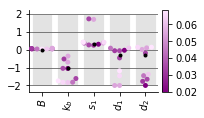

In [503]:
# use
# df_top_thetas_EA = pd.DataFrame(runs_sort2[1])
# df_top_thetas_EA.columns = labelnames

num_plt = 100
df_plt = pd.DataFrame(runs_sort2[1][:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

synth_data_df = pd.DataFrame(var).T
synth_data_df.columns = labelnames
synth_data_df_log = synth_data_df.apply(np.log10)


plt_param_ranges(labelnames, dims, runs_sort2, 10,  synth_data=synth_data_df_log) #black dot is best param
# plt.savefig(fig_folder+'5B3.jpg', dpi=300,bbox_inches='tight')

(-3, 3)

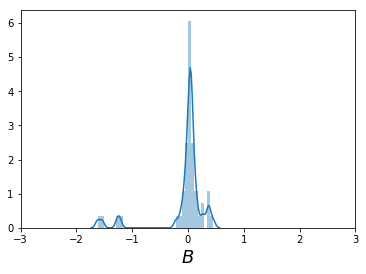

In [506]:

# use
sns.distplot(df_plt_log[labelnames[0]])
plt.xlim(-3,3)

(-3, 3)

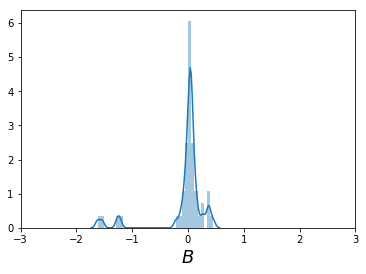

In [507]:
# use
sns.distplot(df_plt_log[labelnames[0]])
plt.xlim(-3,3)

In [526]:
param_mses = []

for param in runs_sort2[1][:10]:
    diff = np.sum(np.absolute(param-var))
    param_mses.append(diff)
# 1/0
print(np.argmin(param_mses))
print(param_mses)

0
[1.0491461854179596, 1.4507140217057608, 50.742014256381125, 1.1406254016008557, 1.6416753644804385, 1.8185269045942216, 48.511816842475135, 1.9472956180802703, 2.0931909258940387, 2.0705112899720923]


3
[31.377279178907465, 29.83636624431907, 35.0779595641009, 29.161145017265614, 29.428621327773307, 43.16608144789633, 33.35281024570025, 30.29595804126305, 40.311495211454826, 38.441391761605765]


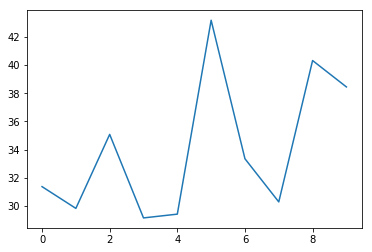

In [528]:
# use
# x and y species' MSES

mses_YX = []
for param in runs_sort2[1]:
    mses_YX.append(scorefxn2(param, [Y_data_synth2], [X_data_synth2], synth_time2, convert=False))
    
# plt.plot(range(len(runs2)), mses_YX)

plt.plot(range(len(runs2))[:10], mses_YX[:10])

print(np.argmin(mses_YX[:10]))
print(mses_YX[:10])

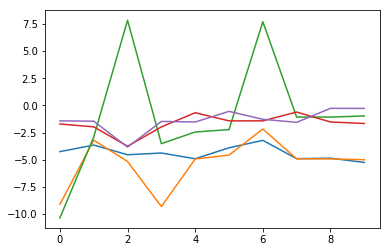

In [518]:
# use
##sum of squared errors for each parameter set, log 

sse_params = []
for param in runs_sort2[1]:
    sse = [(x-p)**2 for x, p in zip(var,param)]
    sse_params.append(sse)
    
# plt.plot(range(len(runs2)), sse_params)
plt.plot(range(len(runs2))[:10], np.log(sse_params))



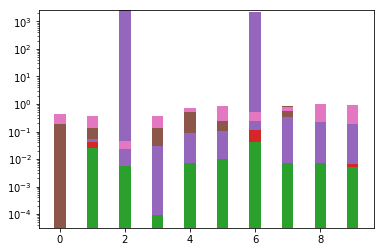

In [519]:
sse_params_arr = np.array(sse_params[:10])

N = 10
n1 = sse_params_arr[:,0]
n2 = sse_params_arr[:,1]
# menStd = (2, 3, 4, 1, 2)
# womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, n1, width)
p2 = plt.bar(ind, n2, width,
             bottom=n1)

plt.bar(ind, sse_params_arr[:,0], width)
for i in range(1,5):
    n = sse_params_arr[:,i]
    plt.bar(ind, n, width,
             bottom=sse_params_arr[:,i-1])
    
plt.yscale('log')
# plt.ylabel('Scores')
# plt.title('Scores by group and gender')
# plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
# plt.yticks(np.arange(0, 81, 10))
# plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

## Runs to 1 min interval, both Y and X

In [381]:
runs3 = run([Y_data_synth2], [X_data_synth2], synth_time2)

0.0% complete.
10.0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


20.0% complete.
30.0% complete.
40.0% complete.
50.0% complete.
60.0% complete.
70.0% complete.
80.0% complete.
90.0% complete.


In [382]:
sim_data3 = []

runs_sort3 = sort_sims(runs3)

for param in runs_sort3[1]:
    ss_inits = run_ss(model, inits, param)
    sim_datum = run_experiment(model, ss_inits, time, param, sig) 
    sim_data3.append(sim_datum)

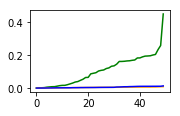

In [383]:
##sse  / # datapoints <- incorrect

plt.plot(range(len(runs3)), runs_sort3[0]/len(Y_data_synth2)/2, color='green')
plt.plot(range(len(runs3)), runs_sort2[0]/len(Y_data_synth2), color='orange')
plt.plot(range(len(runs3)), runs_sort[0]/len(Y_data_synth), color='blue')

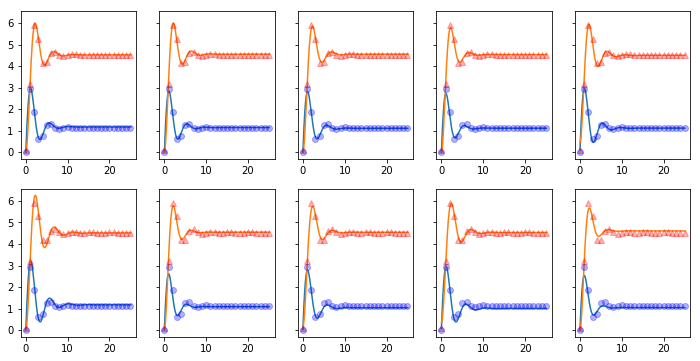

In [384]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6), sharey=True)
for datum, i in zip(sim_data3[:5], range(5)):
    axs[0,i].plot(time, datum)
    axs[0,i].plot(synth_time2, Y_data_synth2, color='red', marker='^', linestyle="None", alpha=.3)
    axs[0,i].plot(synth_time2, X_data_synth2, color='blue', marker='o', linestyle="None", alpha=.3)
for datum, i in zip(sim_data3[5:10], range(5)):
    axs[1,i].plot(time, datum)
    axs[1,i].plot(synth_time2, Y_data_synth2, color='red', marker='^', linestyle="None", alpha=.3)
    axs[1,i].plot(synth_time2, X_data_synth2, color='blue', marker='o', linestyle="None", alpha=.3)

   $B$  $k_b$    $s_1$    $d_1$    $d_2$
0  0.0   -1.0  0.30103 -0.30103 -0.30103


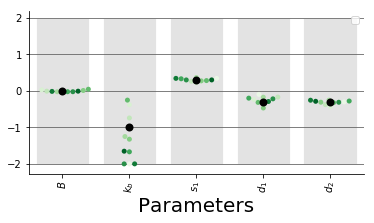

In [385]:
# use
# df_top_thetas_EA = pd.DataFrame(runs_sort2[1])
# df_top_thetas_EA.columns = labelnames

num_plt = 100
df_plt = pd.DataFrame(runs_sort3[1][:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

synth_data_df = pd.DataFrame(var).T
synth_data_df.columns = labelnames
synth_data_df_log = synth_data_df.apply(np.log10)


plt_param_ranges(labelnames, dims, runs_sort3, 10,  synth_data=synth_data_df_log) #black dot is best param


In [541]:
error1 =[]
for param in runs_sort[1]:
    error = scorefxn1(param, [Y_data_synth], synth_time)
    error1.append(error)
    
error2 =[]
for param in runs_sort2[1]:
    error = scorefxn1(param, [Y_data_synth2], synth_time2)
    error2.append(error)
    
error3 =[]
for param in runs_sort3[1]:
    error = scorefxn2(param, [Y_data_synth2],[X_data_synth2], synth_time2)
    error3.append(error)
    
error4 =[]
for param in runs_sort4[1]:
    error = scorefxn2(param, [Y_data_synth],[X_data_synth], synth_time)
    error4.append(error)

In [420]:
test = np.sort(error1)
print(test)

[0.00317052 0.00502865 0.00610948 0.00775615 0.00896865 0.00899498
 0.00900863 0.00902675 0.0101765  0.01100307 0.01196153 0.01199275
 0.01219195 0.0128505  0.01329926 0.01485445 0.01844714 0.01901084
 0.01940497 0.02186576 0.02211392 0.02212233 0.02262288 0.02473797
 0.02605512 0.02668924 0.02715334 0.03018561 0.03162048 0.03958447
 0.04815865 0.04879756 0.05219525 0.05410872 0.05493332 0.06348489
 0.0647494  0.06800943 0.07312693 0.0755553  0.08012572 0.08438029
 0.0920454  0.09359578 0.09405417 0.09562606 0.09601334 0.09645201
 0.09773614 0.11049081]


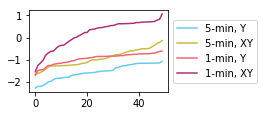

In [550]:
#use
plt.plot(range(len(runs3)), np.log10(np.sort(error1)), color='#66ccee',label='5-min, Y') #5 min
plt.plot(range(len(runs3)), np.log10(np.sort(error4)/2), color='#ccbb44',label='5-min, XY') #10 min both YX
plt.plot(range(len(runs3)), np.log10(np.sort(error2)), color='#ee6677',label='1-min, Y')#1 min just Y
plt.plot(range(len(runs3)), np.log10(np.sort(error3)/2), color='#aa3377',label='1-min, XY') #1 min both YX

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.savefig(fig_folder+'8C.jpg', dpi=300,bbox_inches='tight')

# model no neg

In [553]:
def model2(inits, t, var, sig):
    X, Y = inits 
    B, kb, s1, d1, d2 = var
       
    
    dX = kb + sig - d1 * X
    dY = s1 * X - d2*Y  # * (Y_t-Y)
     
    return dX, dY

In [35]:
runs_noneg = run([Y_data_synth], [X_data_synth],synth_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.0% complete.
10.0% complete.
20.0% complete.
30.0% complete.
40.0% complete.
50.0% complete.
60.0% complete.
70.0% complete.
80.0% complete.
90.0% complete.


In [554]:
sim_data_nn = []

runs_sort_nn = sort_sims(runs_noneg)

for param in runs_sort_nn[1]:
    ss_inits = run_ss(model2, inits, param)
    sim_datum = run_experiment(model2, ss_inits, time, param, sig) 
    sim_data_nn.append(sim_datum)

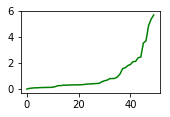

In [555]:
plt.plot(range(len(runs_noneg)), runs_sort_nn[0], color='green')


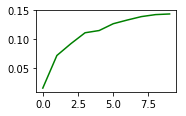

In [556]:
plt.plot(range(len(runs_noneg))[:10], runs_sort_nn[0][:10], color='green')


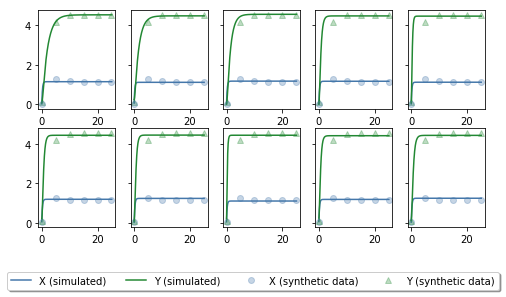

In [558]:
fig, axs = plt.subplots(2, 5, figsize=(8, 4), sharey=True)
for datum, i in zip(sim_data_nn[:5], range(5)):
    axs[0,i].plot(time, datum[:,0], color=blue, label='X (simulated)')
    axs[0,i].plot(time, datum[:,1], color=green, label='Y (simulated)')
    axs[0,i].plot(synth_time, Y_data_synth, color=green, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')
    axs[0,i].plot(synth_time, X_data_synth, color=blue, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')


for datum, i in zip(sim_data_nn[5:10], range(5)):
    axs[1,i].plot(time, datum[:,0], color=blue, label='X (simulated)')
    axs[1,i].plot(time, datum[:,1], color=green, label='Y (simulated)')
    axs[1,i].plot(synth_time, X_data_synth, color=blue, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')
    axs[1,i].plot(synth_time, Y_data_synth, color=green, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')

plt.legend(loc='upper right', bbox_to_anchor=(1.25, -0.40),
          fancybox=True, shadow=True, ncol=5)


plt.savefig(fig_folder+'9.jpg', dpi=300,bbox_inches='tight')

   $B$  $k_b$    $s_1$    $d_1$    $d_2$
0  0.0   -1.0  0.30103 -0.30103 -0.30103


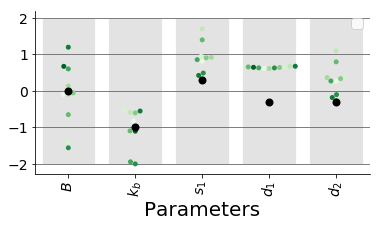

In [42]:
# use
# df_top_thetas_EA = pd.DataFrame(runs_sort2[1])
# df_top_thetas_EA.columns = labelnames

num_plt = 100
df_plt = pd.DataFrame(runs_sort_nn[1][:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

synth_data_df = pd.DataFrame(var).T
synth_data_df.columns = labelnames
synth_data_df_log = synth_data_df.apply(np.log10)


plt_param_ranges(labelnames, dims, runs_sort_nn, 10,  synth_data=synth_data_df_log) #black dot is best param


In [107]:
fp = []

def find_fixed_points(r):
    for x in range(r):
        for y in range(r):
            if ((f(x,y) == 0) and (g(x,y) == 0)):
                fp.append((x,y))
                print('The system has a fixed point in %s,%s' % (x,y))
    return fp

find_fixed_points(5001)

[]

# Model driven experimental design

In [660]:
def model(inits, t, var, sig):
    X, Y = inits 
    B, kb, s1, d1, d2 = var
    d2 = 0
    if t > 0:
        sig = 5
    if t > 10:
        sig = 0
    if t > 20:
        sig = 5
        
    dX = kb + sig - B * Y - d1 * X
    dY = s1 * X - d2*Y  # * (Y_t-Y)
     
    return dX, dY


def model2(inits, t, var, sig):
    X, Y = inits 
    B, kb, s1, d1, d2 = var
#     d2 = 0

    if t > 0:
        sig = 5
    if t > 10:
        sig = 0
    if t > 20:
        sig = 5
    
    dX = kb + sig - d1 * X
    dY = s1 * X - d2*Y  # * (Y_t-Y)
     
    return dX, dY

In [563]:
null_model_params = runs_sort_nn[1][0]
true_model_params = runs_sort4[1][0]

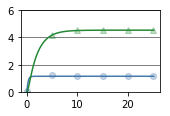

In [658]:
ninits = run_ss(model, [0,0], param)
ndatum = run_experiment(model2, ninits, time, null_model_params, sig) 

plt.plot(time, ndatum[:,0], color=blue, label='X')
plt.plot(time, ndatum[:,1], color=green, label='Y')

plt.plot(synth_time, X_data_synth, color=blue, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')
plt.plot(synth_time, Y_data_synth, color=green, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')

plt.ylim(0, 6)
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

# plt.savefig(fig_folder+'101.jpg', dpi=300,bbox_inches='tight')

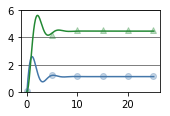

In [659]:
trinits = run_ss(model, [0,0], param)
trdatum = run_experiment(model, trinits, time, true_model_params, sig) 

plt.plot(time, trdatum[:,0], color=blue, label='X')
plt.plot(time, trdatum[:,1], color=green, label='Y')

plt.plot(synth_time, X_data_synth, color=blue, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')
plt.plot(synth_time, Y_data_synth, color=green, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')

plt.ylim(0, 6)
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

# plt.savefig(fig_folder+'102.jpg', dpi=300,bbox_inches='tight')

## Different inits

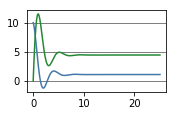

In [637]:
tdatum = run_experiment(model, [10,0], time, true_model_params, sig) 
# print(tdatum)
plt.plot(time, tdatum[:,0], color=blue, label='X')
plt.plot(time, tdatum[:,1], color=green, label='Y')
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig(fig_folder+'10ab.jpg', dpi=300,bbox_inches='tight')

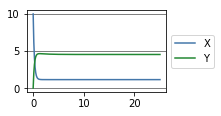

In [636]:
# tinits = run_ss(model2, [100,100], param)
tdatum = run_experiment(model2, [10,0], time, null_model_params, sig) 
# print(tdatum)
plt.plot(time, tdatum[:,0], color=blue, label='X')
plt.plot(time, tdatum[:,1], color=green, label='Y')
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(fig_folder+'10a1.jpg', dpi=300,bbox_inches='tight')

## Different input

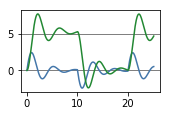

In [661]:
t2inits = run_ss(model, [0,0], param)
t2datum = run_experiment(model, t2inits, time, true_model_params, sig) 
# print(tdatum)
plt.plot(time, t2datum[:,0], color=blue, label='X')
plt.plot(time, t2datum[:,1], color=green, label='Y')

# plt.ylim(-2, 6)
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

# plt.savefig(fig_folder+'10b1.jpg', dpi=300,bbox_inches='tight')

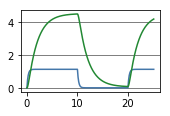

In [662]:
t2inits = run_ss(model, [0,0], param)
t2datum = run_experiment(model2, t2inits, time, null_model_params, sig) 
# print(tdatum)
plt.plot(time, t2datum[:,0], color=blue, label='X')
plt.plot(time, t2datum[:,1], color=green, label='Y')

# plt.ylim(-2, 6)
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

# plt.savefig(fig_folder+'10b2.jpg', dpi=300,bbox_inches='tight')

## Different structures

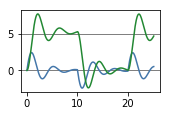

In [663]:
t2inits = run_ss(model, [0,0], param)
t2datum = run_experiment(model, t2inits, time, true_model_params, sig) 
# print(tdatum)
plt.plot(time, t2datum[:,0], color=blue, label='X')
plt.plot(time, t2datum[:,1], color=green, label='Y')

# plt.ylim(-2, 6)
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

# plt.savefig(fig_folder+'10c1.jpg', dpi=300,bbox_inches='tight')

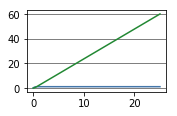

In [616]:
t2inits = run_ss(model, [0,0], param)
t2datum = run_experiment(model2, t2inits, time, null_model_params, sig) 
# print(tdatum)
plt.plot(time, t2datum[:,0], color=blue, label='X')
plt.plot(time, t2datum[:,1], color=green, label='Y')

# plt.ylim(-2, 6)
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

# plt.savefig(fig_folder+'10c2.jpg', dpi=300,bbox_inches='tight')